In [46]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, lit, avg, posexplode, count
import requests
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType, ArrayType, IntegerType, StringType

In [47]:
spark = SparkSession.builder \
    .appName("salary_prediction") \
    .config("spark.executor.memory", "6g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

In [48]:
# import data
file_path = "stack-overflow-developer-survey-2024/survey_results_public.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [49]:
# remove invalid respondents and check compensation is not NA
filtered_df = df.filter((df.Check == "Apples")&(df.CompTotal != "NA"))

In [50]:
# drop irrelavent columns 
col_dropped = filtered_df.drop(
    "ResponseId","Check","CodingActivities","LearnCodeOnline","TechDoc","YearsCodePro","PurchaseInfluence","BuyNewTool","BuildvsBuy",
    "TechEndorse","LanguageWantToWorkWith","LanguageAdmired","DatabaseWantToWorkWith","DatabaseAdmired","PlatformWantToWorkWith",
    "PlatformAdmired","WebframeWantToWorkWith","WebframeAdmired","EmbeddedWantToWorkWith","EmbeddedAdmired","MiscTechWantToWorkWith",
    "MiscTechAdmired","ToolsTechWantToWorkWith","ToolsTechAdmired","NEWCollabToolsWantToWorkWith","NEWCollabToolsAdmired",
    "OpSysPersonal use","OfficeStackAsyncWantToWorkWith","OfficeStackAsyncAdmired","OfficeStackSyncWantToWorkWith","OfficeStackSyncAdmired",
    "AISearchDevWantToWorkWith","AISearchDevAdmired","NEWSOSites","SOVisitFreq","SOAccount","SOPartFreq","SOHow","SOComm","AIBen","AIAcc",
    "AIComplex","AIToolCurrently Using","AIToolInterested in Using","AIToolNot interested in Using","AINextMuch more integrated",
    "AINextNo change","AINextMore integrated","AINextLess integrated","AINextMuch less integrated","AIThreat","AIEthics","AIChallenges",
    "TBranch","Knowledge_1","Knowledge_2","Knowledge_3","Knowledge_4","Knowledge_5","Knowledge_6","Knowledge_7","Knowledge_8","Knowledge_9",
    "Frequency_1","Frequency_2","Frequency_3","TimeSearching","TimeAnswering","Frustration","ProfessionalTech","ProfessionalCloud",
    "ProfessionalQuestion","JobSatPoints_1","JobSatPoints_4","JobSatPoints_5","JobSatPoints_6","JobSatPoints_7","JobSatPoints_8",
    "JobSatPoints_9","JobSatPoints_10","JobSatPoints_11","SurveyLength","SurveyEase","ConvertedCompYearly","JobSat"
)

In [51]:
# maps for data transformation
learn_code_map = {
    "Books / Physical media": 0, "Coding Bootcamp": 1, "Colleague": 2, "Friend or family member": 3, "Online Courses or Certification": 4, 
    "On the job training": 5, "Other online resources (e.g., videos, blogs, forum, online community)": 6, 
    "School (i.e., University, College, etc)": 7
}

languages_map = {
    'Ada': 0, 'Apex': 1, 'Assembly': 2, 'Bash/Shell (all shells)': 3, 'C': 4, 'C#': 5, 'C++': 6, 'Clojure': 7, 'Cobol': 8, 'Crystal': 9, 
    'Dart': 10, 'Delphi': 11, 'Elixir': 12, 'Erlang': 13, 'F#': 14, 'Fortran': 15, 'GDScript': 16, 'Go': 17, 'Groovy': 18, 'Haskell': 19, 
    'HTML/CSS': 20, 'Java': 21, 'JavaScript': 22, 'Julia': 23, 'Kotlin': 24, 'Lisp': 25, 'Lua': 26, 'MATLAB': 27, 'MicroPython': 28, 
    'Nim': 29, 'Objective-C': 30, 'OCaml': 31, 'Perl': 32, 'PHP': 33, 'PowerShell': 34, 'Prolog': 35, 'Python': 36, 'R': 37, 'Ruby': 38, 
    'Rust': 39, 'Scala': 40, 'Solidity': 41, 'SQL': 42, 'Swift': 43, 'TypeScript': 44, 'VBA': 45, 'Visual Basic (.Net)': 46, 
    'Zephyr': 47, 'Zig': 48
}

databases_map = {
    'BigQuery': 0, 'Cassandra': 1, 'Clickhouse': 2, 'Cloud Firestore': 3, 'Cockroachdb': 4, 'Cosmos DB': 5, 'Couch DB': 6, 'Couchbase': 7, 
    'Databricks SQL': 8, 'Datomic': 9, 'DuckDB': 10, 'Dynamodb': 11, 'Elasticsearch': 12, 'EventStoreDB': 13, 
    'Firebase Realtime Database': 14, 'Firebird': 15, 'H2': 16, 'IBM DB2': 17, 'InfluxDB': 18, 'MariaDB': 19, 'Microsoft Access': 20, 
    'Microsoft SQL Server': 21, 'MongoDB': 22, 'MySQL': 23, 'Neo4J': 24, 'Oracle': 25, 'PostgreSQL': 26, 'Presto': 27, 'RavenDB': 28, 
    'Redis': 29, 'Snowflake': 30, 'Solr': 31, 'SQLite': 32, 'Supabase': 33, 'TiDB': 34
}

clouds_map = {
    'Alibaba Cloud': 0, 'Amazon Web Services (AWS)': 1, 'Cloudflare': 2, 'Colocation': 3, 'Databricks': 4, 'Digital Ocean': 5, 'Firebase': 6,
    'Fly.io': 7, 'Google Cloud': 8, 'Heroku': 9, 'Hetzner': 10, 'IBM Cloud Or Watson': 11, 'Linode': 12, 'Managed Hosting': 13, 
    'Microsoft Azure': 14, 'Netlify': 15, 'OpenShift': 16, 'OpenStack': 17, 'Oracle Cloud Infrastructure (OCI)': 18, 'OVH': 19, 
    'PythonAnywhere': 20, 'Render': 21, 'Scaleway': 22, 'Supabase': 23, 'Vercel': 24, 'VMware': 25, 'Vultr': 26
}

webs_map = {
    'Angular': 0, 'AngularJS': 1, 'ASP.NET': 2, 'ASP.NET CORE': 3, 'Astro': 4, 'Blazor': 5, 'CodeIgniter': 6, 'Deno': 7, 'Django': 8, 
    'Drupal': 9, 'Elm': 10, 'Express': 11, 'FastAPI': 12, 'Fastify': 13, 'Flask': 14, 'Gatsby': 15, 'Htmx': 16, 'jQuery': 17, 'Laravel': 18, 
    'NestJS': 19, 'Next.js': 20, 'Node.js': 21, 'Nuxt.js': 22, 'Phoenix': 23, 'Play Framework': 24, 'React': 25, 'Remix': 26, 
    'Ruby on Rails': 27, 'Solid.js': 28, 'Spring Boot': 29, 'Strapi': 30, 'Svelte': 31, 'Symfony': 32, 'Vue.js': 33, 'WordPress': 34, 
    'Yii 2': 35
}

embeds_map = {
    'Arduino': 0, 'Boost.Test': 1, 'build2': 2, 'Catch2': 3, 'CMake': 4, 'Cargo': 5, 'cppunit': 6, 'CUTE': 7, 'doctest': 8, 'GNU GCC': 9, 
    "LLVM's Clang": 10, 'Meson': 11, 'Micronaut': 12, 'MSVC': 13, 'Ninja': 14, 'PlatformIO': 15, 'QMake': 16, 'Rasberry Pi': 17, 
    'SCons': 18, 'ZMK': 19
}

misc_techs_map = {
    '.NET (5+)': 0, '.NET Framework (1.0 - 4.8)': 1, '.NET MAUI': 2, 'Apache Kafka': 3, 'Apache Spark': 4, 'Capacitor': 5, 'Cordova': 6, 
    'CUDA': 7, 'DirectX': 8, 'Electron': 9, 'Flutter': 10, 'GTK': 11, 'Hadoop': 12, 'Hugging Face Transformers': 13, 'Ionic': 14, 'JAX': 15, 
    'Keras': 16, 'Ktor': 17, 'MFC': 18, 'mlflow': 19, 'NumPy': 20, 'OpenCL': 21, 'Opencv': 22, 'OpenGL': 23, 'Pandas': 24, 'Qt': 25, 
    'Quarkus': 26, 'RabbitMQ': 27, 'React Native': 28, 'Roslyn': 29, 'Ruff': 30, 'Scikit-Learn': 31, 'Spring Framework': 32, 'SwiftUI': 33, 
    'Tauri': 34, 'TensorFlow': 35, 'Tidyverse': 36, 'Torch/PyTorch': 37, 'Xamarin': 38
}

tech_tools_map = {
    'Ansible': 0, 'Ant': 1, 'APT': 2, 'Bun': 3, 'Chef': 4, 'Chocolatey': 5, 'Composer': 6, 'Dagger': 7, 'Docker': 8, 'Godot': 9, 
    'Google Test': 10, 'Gradle': 11, 'Homebrew': 12, 'Kubernetes': 13, 'Make': 14, 'Maven (build tool)': 15, 'MSBuild': 16, 'Ninja': 17, 
    'Nix': 18, 'npm': 19, 'NuGet': 20, 'Pacman': 21, 'Pip': 22, 'pnpm': 23, 'Podman': 24, 'Pulumi': 25, 'Puppet': 26, 'Terraform': 27, 
    'Unity 3D': 28, 'Unreal Engine': 29, 'Visual Studio Solution': 30, 'Vite': 31, 'Webpack': 32, 'Yarn': 33
}

collab_tools_map = {
    'Android Studio': 0, 'BBEdit': 1, 'CLion': 2, 'Code::Blocks': 3, 'DataGrip': 4, 'Eclipse': 5, 'Emacs': 6, 'Fleet': 7, 'Geany': 8, 
    'Goland': 9, 'Helix': 10, 'IntelliJ IDEA': 11, 'IPython': 12, 'Jupyter Notebook/JupyterLab': 13, 'Kate': 14, 'Nano': 15, 'Neovim': 16, 
    'Netbeans': 17, 'Notepad++': 18, 'PhpStorm': 19, 'PyCharm': 20, 'Qt Creator': 21, 'Rad Studio (Delphi, C++ Builder)': 22, 'Rider': 23, 
    'RStudio': 24, 'RubyMine': 25, 'Spacemacs': 26, 'Spyder': 27, 'Sublime Text': 28, 'Vim': 29, 'Visual Studio': 30, 
    'Visual Studio Code': 31, 'VSCodium': 32, 'WebStorm': 33, 'Xcode': 34
}

oss_map = {
    'AIX': 0, 'Android': 1, 'Arch': 2, 'BSD': 3, 'ChromeOS': 4, 'Cygwin': 5, 'Debian': 6, 'Fedora': 7, 'Haiku': 8, 'iOS': 9, 'iPadOS': 10, 
    'MacOS': 11, 'Other Linux-based': 12, 'Red Hat': 13, 'Solaris': 14, 'Ubuntu': 15, 'Windows': 16, 'Windows Subsystem for Linux (WSL)': 17
}

office_stack_async_map = {
    'Airtable': 0, 'Asana': 1, 'Azure Devops': 2, 'Basecamp': 3, 'Clickup': 4, 'Confluence': 5, 'Doxygen': 6, 'GitHub Discussions': 7, 
    'Jira': 8, 'Linear': 9, 'Lucid': 10, 'Markdown File': 11, 'Microsoft Lists': 12, 'Microsoft Planner': 13, 'Miro': 14, 'Monday.com': 15, 
    'Notion': 16, 'Obsidian': 17, 'Redmine': 18, 'Shortcut': 19, 'Smartsheet': 20, 'Stack Overflow for Teams': 21, 'Trello': 22, 'Wikis': 23,
    'YouTrack': 24
}

office_stack_sync_map = {
    'Cisco Webex Teams': 0, 'Coolfire Core': 1, 'Discord': 2, 'Google Chat': 3, 'Google Meet': 4, 'IRC': 5, 'Jitsi': 6, 'Matrix': 7, 
    'Mattermost': 8, 'Microsoft Teams': 9, 'Ringcentral': 10, 'Rocketchat': 11, 'Signal': 12, 'Skype': 13, 'Slack': 14, 'Symphony': 15, 
    'Telegram': 16, 'Unify Circuit': 17, 'Whatsapp': 18, 'Wickr': 19, 'Wire': 20, 'Zoom': 21, 'Zulip': 22
}

ai_tools_map = {
    'Andi': 0, 'AskCodi': 1, 'Amazon Q': 2, 'Bing AI': 3, 'ChatGPT': 4, 'Claude': 5, 'Codeium': 6, 'Cody': 7, 'GitHub Copilot': 8, 
    'Google Gemini': 9, 'Lightning AI': 10, 'Meta AI': 11, 'Metaphor': 12, 'Neeva AI': 13, 'OpenAI Codex': 14, 'Perplexity AI': 15, 
    'Phind': 16, 'Quora Poe': 17, 'Replit Ghostwriter': 18, 'WolframAlpha': 19, 'Snyk Code': 20, 'Tabnine': 21, 
    'Visual Studio Intellicode': 22, 'Whispr AI': 23, 'You.com': 24
}

salary_label = {
    "<=40k": 0, "40k-45k": 1, "45k-50k": 2, "50k-55k": 3, "55k-60k": 4, "60k-65k": 5, "65k-70k": 6, "70k-75k": 7,
    "75k-80k": 8, "80k-85k": 9, "85k-90k": 10, "90k-95k": 11, "95k-100k": 12, "100k-110k": 13, "110k-120k": 14, "120k-130k": 15,
    "130k-140k": 16, "140k-150k": 17, "150k-200k": 18, ">200k": 19,
}

countries_more_than_100_count = [ 
    "United States of America", "Germany", "United Kingdom of Great Britain and Northern Ireland", "Ukraine", "India", "France", "Canada",
    "Brazil", "Poland", "Netherlands", "Spain", "Italy", "Australia", "Sweden", "Switzerland", "Austria", "Czech Republic", 
    "Russian Federation", "Denmark", "Norway", "Belgium", "Israel", "Portugal", "New Zealand", "Turkey", "Finland", "Romania", "Mexico",
    "Greece", "South Africa", "Hungary", "Argentina", "Iran, Islamic Republic of...", "Pakistan", "Ireland", "Bulgaria", "Japan", 
    "Bangladesh", "Serbia", "Slovakia", "Taiwan", "Indonesia", "Colombia", "Lithuania", "Croatia", "China", "Slovenia", "Nigeria" 
]

In [52]:
# fetch currency conversion rates
api_key = "a82429fa6fdb42f8855e6efc1d92e60c"
url = f"https://openexchangerates.org/api/latest.json?app_id={api_key}"
conversion_rates = requests.get(url).json()["rates"]

def convert_to_USD(currency, amount):
    if not currency or not amount:
        return None
    currency = currency.split()[0]
    if currency not in conversion_rates:
        return None
    if 'e' in amount or '.' in amount:
        integer_amount = int(float(amount))
    else:
        integer_amount = int(amount)
    return round(int(integer_amount)/conversion_rates[currency], 2)

def generate_attribute_arr(attr, indicator): 
    if indicator == "learn_code":
        attr_map = learn_code_map
    if indicator == "language":
        attr_map = languages_map
    if indicator == "database":
        attr_map = databases_map
    if indicator == "cloud":
        attr_map = clouds_map
    if indicator == "web":
        attr_map = webs_map
    if indicator == "embed":
        attr_map = embeds_map
    if indicator == "misc_tech":
        attr_map = misc_techs_map
    if indicator == "tech_tool":
        attr_map = tech_tools_map
    if indicator == "collab_tool":
        attr_map = collab_tools_map
    if indicator == "os":
        attr_map = oss_map
    if indicator == "office_stack_async":
        attr_map = office_stack_async_map
    if indicator == "office_stack_sync":
        attr_map = office_stack_sync_map
    if indicator == "ai_tool":
        attr_map = ai_tools_map

    if not attr:
        return [None] * len(attr_map)

    arr = [0] * len(attr_map)
    for i in attr.split(';'):
        if i in attr_map:
            arr[attr_map[i]] = 1
    return arr 

def generate_label(salary):
    if not salary:
        return
    if salary <= 40000:
        return 0
    elif salary <= 45000:
        return 1
    elif salary <= 50000:
        return 2
    elif salary <= 55000:
        return 3
    elif salary <= 60000:
        return 4    
    elif salary <= 65000:
        return 5
    elif salary <= 70000:
        return 6
    elif salary <= 75000:
        return 7
    elif salary <= 80000:
        return 8
    elif salary <= 85000:
        return 9
    elif salary <= 90000:
        return 10
    elif salary <= 95000:
        return 11
    elif salary <= 100000:
        return 12
    elif salary <= 110000:
        return 13
    elif salary <= 120000:
        return 14
    elif salary <= 130000:
        return 15
    elif salary <= 140000:
        return 16
    elif salary <= 150000:
        return 17
    elif salary <= 200000:
        return 19
    else:
        return 19

# convert contries count < 100 to other
def convert_country(country):
    if country in countries_more_than_100_count:
        return country
    return "other"

convert_to_usd_udf = udf(convert_to_USD, FloatType())
generate_attribute_arr_udf = udf(generate_attribute_arr, ArrayType(IntegerType()))
generate_label_udf = udf(generate_label, IntegerType())
convert_country_udf = udf(convert_country, StringType())

In [53]:
transformed_df = (
    col_dropped
    .withColumn("MainBranch_index",
                when(col("MainBranch")=="I am a developer by profession", 0)
                .when(col("MainBranch")=="I am not primarily a developer, but I write code sometimes as part of my work/studies", 1)
                .when(col("MainBranch")=="I used to be a developer by profession, but no longer am", 2)
                .when(col("MainBranch")=="I am learning to code", 3)
                .when(col("MainBranch")=="I code primarily as a hobby", 4)
                .when(col("MainBranch")=="None of these", 5))
    .withColumn("Age_index",
                when(col("Age")=="Under 18 years old", 0)
                .when(col("Age")=="18-24 years old", 1)
                .when(col("Age")=="25-34 years old", 2)
                .when(col("Age")=="35-44 years old", 3)
                .when(col("Age")=="45-54 years old", 4)
                .when(col("Age")=="55-64 years old", 5)
                .when(col("Age")=="65 years or older", 6)
                .when(col("Age")=="Prefer not to say", lit(None)))
    .withColumn("Employment_index",
               when(col("Employment")=="Employed, full-time", 0)
                .when(col("Employment")=="Employed, part-time", 0)
                .when(col("Employment")=="Independent contractor, freelancer, or self-employed", 1)
                .when(col("Employment")=="Not employed, but looking for work", 2)
                .when(col("Employment")=="Not employed, and not looking for work", 2)
                .when(col("Employment")=="Student, full-time", 3)
                .when(col("Employment")=="Student, part-time", 3)
                .when(col("Employment")=="Retired", 4)
                .when(col("Employment")=="I prefer not to say", lit(None))
               )
    .withColumn("RemoteWork_index",
               when(col("RemoteWork")=="Remote", 0)
                .when(col("RemoteWork")=="In-person", 1)
                .when(col("RemoteWork")=="Hybrid (some remote, some in-person)", 2)
               )
    .withColumn("EdLevel_index",
               when(col("EdLevel")=="Primary/elementary school", 0)
                .when(col("EdLevel")=="Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)", 1)
                .when(col("EdLevel")=="Some college/university study without earning a degree", 2)
                .when(col("EdLevel")=="Associate degree (A.A., A.S., etc.)", 3)
                .when(col("EdLevel")=="Bachelor’s degree (B.A., B.S., B.Eng., etc.)", 4)
                .when(col("EdLevel")=="Master’s degree (M.A., M.S., M.Eng., MBA, etc.)", 5)
                .when(col("EdLevel")=="Professional degree (JD, MD, Ph.D, Ed.D, etc.)", 6)
                .when(col("EdLevel")=="Something else", lit(None))
               )
    .withColumn("LearnCode_arr", generate_attribute_arr_udf(col("LearnCode"), lit('learn_code')))
    .withColumn("DevType_index",
               when(col("DevType")=="Academic researcher", 0)
                .when(col("DevType")=="Blockchain", 6)
                .when(col("DevType")=="Cloud infrastructure engineer", 4)
                .when(col("DevType")=="Data or business analyst", 1)
                .when(col("DevType")=="Data engineer", 1)
                .when(col("DevType")=="Data scientist or machine learning specialist", 1)
                .when(col("DevType")=="Database administrator", 4)
                .when(col("DevType")=="Designer", 7)
                .when(col("DevType")=="Developer Advocate", 3)
                .when(col("DevType")=="Developer, AI", 1)
                .when(col("DevType")=="Developer, back-end", 2)
                .when(col("DevType")=="Developer, desktop or enterprise applications", 2)
                .when(col("DevType")=="Developer, embedded applications or devices", 2)
                .when(col("DevType")=="Developer Experience", 3)
                .when(col("DevType")=="Developer, front-end", 2)
                .when(col("DevType")=="Developer, full-stack", 2)
                .when(col("DevType")=="Developer, game or graphics", 2)
                .when(col("DevType")=="Developer, mobile", 2)
                .when(col("DevType")=="Developer, QA or test", 5)
                .when(col("DevType")=="DevOps specialist", 4)
                .when(col("DevType")=="Educator", 9)
                .when(col("DevType")=="Engineer, site reliability", 4)
                .when(col("DevType")=="Engineering manager", 8)
                .when(col("DevType")=="Hardware Engineer", 10)
                .when(col("DevType")=="Marketing or sales professional", 9)
                .when(col("DevType")=="Product manager", 8)
                .when(col("DevType")=="Project manager", 8)
                .when(col("DevType")=="Research & Development role", 0)
                .when(col("DevType")=="Scientist", 0)
                .when(col("DevType")=="Senior Executive (C-Suite, VP, etc.)", 8)
                .when(col("DevType")=="Student", 11)
                .when(col("DevType")=="System administrator", 4)
                .when(col("DevType")=="Security professional", 4)
                .otherwise(lit(None))
               )
    .withColumn("OrgSize_index",
               when(col("OrgSize")=="Just me - I am a freelancer, sole proprietor, etc.", 0)
                .when(col("OrgSize")=="2 to 9 employees", 1)
                .when(col("OrgSize")=="10 to 19 employees", 1)
                .when(col("OrgSize")=="20 to 99 employees", 1)
                .when(col("OrgSize")=="100 to 499 employees", 2)
                .when(col("OrgSize")=="500 to 999 employees", 2)
                .when(col("OrgSize")=="1,000 to 4,999 employees", 3)
                .when(col("OrgSize")=="5,000 to 9,999 employees", 3)
                .when(col("OrgSize")=="10,000 or more employees", 4)
                .when(col("OrgSize")=="I don’t know", lit(None))
               )
    .withColumn("Salary_in_USD", 
                when( (col("Currency").isNull() | col("CompTotal").isNull()), lit(None))
                .otherwise(convert_to_usd_udf(col("Currency"), col("CompTotal"))))
    .withColumn("AISelect_index",
               when(col("AISelect")=="Yes", 1)
                .when(col("AISelect")=="No, but I plan to soon", 0)
                .when(col("AISelect")=="No, and I don't plan to", 0)
               )
    .withColumn("AISent_index",
               when(col("AISent")=="Very favorable", 0)
                .when(col("AISent")=="Favorable", 0)
                .when(col("AISent")=="Indifferent", 1)
                .when(col("AISent")=="Unfavorable", 2)
                .when(col("AISent")=="Very unfavorable", 2)
                .when(col("AISent")=="Unsure", 3)
               )
    .withColumn("ICorPM_index",
               when(col("ICorPM")=="Individual contributor", 0)
                .when(col("ICorPM")=="People manager", 1)
               )
    .withColumn("Industry_index",
               when(col("Industry")=="Software Development", 0)
                .when(col("Industry")=="Computer Systems Design and Services", 1)
                .when(col("Industry")=="Internet, Telecomm or Information Services", 2)
                .when(col("Industry")=="Fintech", 3)
                .when(col("Industry")=="Energy", 4)
                .when(col("Industry")=="Government", 5)
                .when(col("Industry")=="Banking/Financial Services", 6)
                .when(col("Industry")=="Manufacturing", 7)
                .when(col("Industry")=="Transportation, or Supply Chain", 8)
                .when(col("Industry")=="Healthcare", 9)
                .when(col("Industry")=="Retail and Consumer Services", 10)
                .when(col("Industry")=="Higher Education", 11)
                .when(col("Industry")=="Media & Advertising Services", 12)
                .when(col("Industry")=="Insurance", 13)
                .otherwise(lit(None))
               )
    .withColumn("LanguageHaveWorkedWith_arr", generate_attribute_arr_udf(col("LanguageHaveWorkedWith"), lit("language")))
    .withColumn("DatabaseHaveWorkedWith_arr", generate_attribute_arr_udf(col("DatabaseHaveWorkedWith"), lit("database")))
    .withColumn("PlatformHaveWorkedWith_arr", generate_attribute_arr_udf(col("PlatformHaveWorkedWith"), lit("cloud")))
    .withColumn("WebframeHaveWorkedWith_arr", generate_attribute_arr_udf(col("WebframeHaveWorkedWith"), lit("web")))
    .withColumn("EmbeddedHaveWorkedWith_arr", generate_attribute_arr_udf(col("EmbeddedHaveWorkedWith"), lit("embed")))
    .withColumn("MiscTechHaveWorkedWith_arr", generate_attribute_arr_udf(col("MiscTechHaveWorkedWith"), lit("misc_tech")))
    .withColumn("ToolsTechHaveWorkedWith_arr", generate_attribute_arr_udf(col("ToolsTechHaveWorkedWith"), lit("tech_tool")))
    .withColumn("NEWCollabToolsHaveWorkedWith_arr", generate_attribute_arr_udf(col("NEWCollabToolsHaveWorkedWith"), lit("collab_tool")))
    .withColumn("OpSysProfessionalUse_arr", generate_attribute_arr_udf(col("OpSysProfessional use"), lit("os")))
    .withColumn("OfficeStackAsyncHaveWorkedWith_arr",
                generate_attribute_arr_udf(col("OfficeStackAsyncHaveWorkedWith"), lit("office_stack_async")))
    .withColumn("OfficeStackSyncHaveWorkedWith_arr", 
                generate_attribute_arr_udf(col("OfficeStackSyncHaveWorkedWith"), lit("office_stack_sync")))
    .withColumn("AISearchDevHaveWorkedWith_arr", generate_attribute_arr_udf(col("AISearchDevHaveWorkedWith"), lit("ai_tool")))
    .withColumn("YearsCode", col_dropped["YearsCode"].cast(IntegerType()))
    .withColumn("WorkExp", col_dropped["WorkExp"].cast(IntegerType()))
    .withColumn("Country_reduced", 
                 when( col("Country").isNull(), lit(None))
                .otherwise(convert_country_udf(col("Country"))))
)

In [54]:
filtered_transformed_df = transformed_df.filter(
    ~((col("Salary_in_USD").isNull())|(col("Salary_in_USD") == float("inf"))|(col("Salary_in_USD") > float("1E6")))
)

In [11]:
# x = filtered_transformed_df.groupBy("Country").count()
# sorted_country_count = x.orderBy("count", ascending=False)
# sorted_country_count.show(n=200, truncate=False)
# filtered_transformed_df.select("Country_reduced").distinct().count()

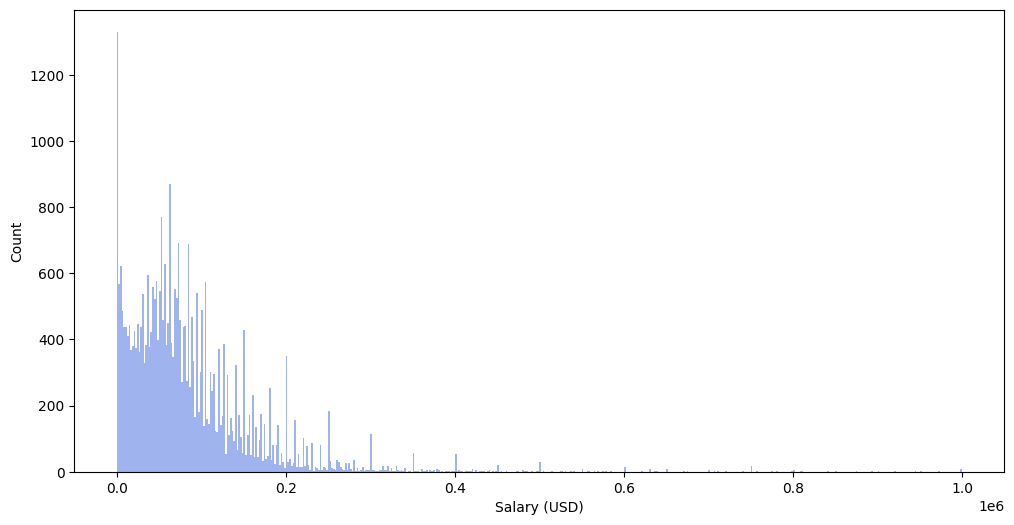

In [12]:
import matplotlib.pyplot as plt
salaries_pandas_df = filtered_transformed_df.select("Salary_in_USD").toPandas()
plt.figure(figsize=(12, 6))
plt.hist(salaries_pandas_df["Salary_in_USD"], bins=500, alpha=0.5, label="Salary", color="royalblue")
plt.xlabel("Salary (USD)")
plt.ylabel("Count")
plt.show()

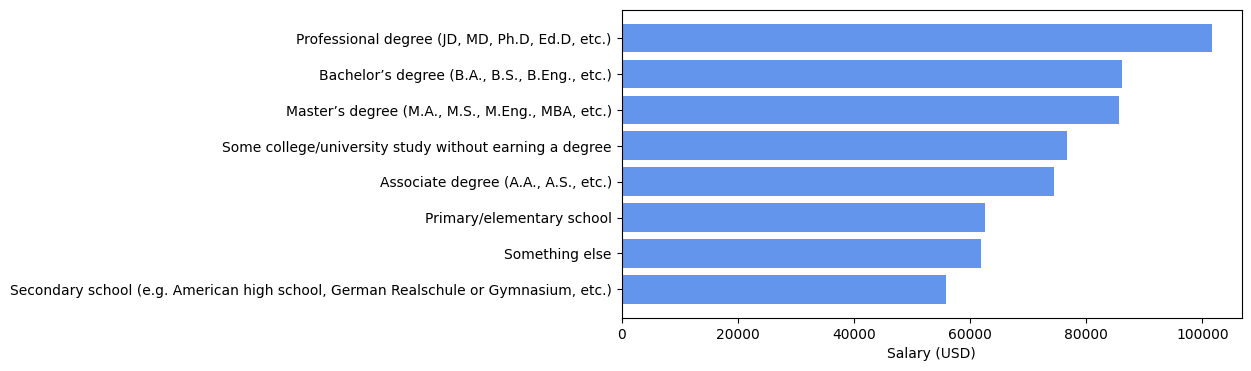

In [13]:
ed_df = filtered_transformed_df.groupBy("EdLevel").agg(avg("Salary_in_USD").alias("average_salary")).sort("average_salary").toPandas()
plt.figure(figsize=(8, 4))
plt.barh(ed_df["EdLevel"], ed_df["average_salary"], color="cornflowerblue")
plt.xlabel("Salary (USD)")
plt.show()

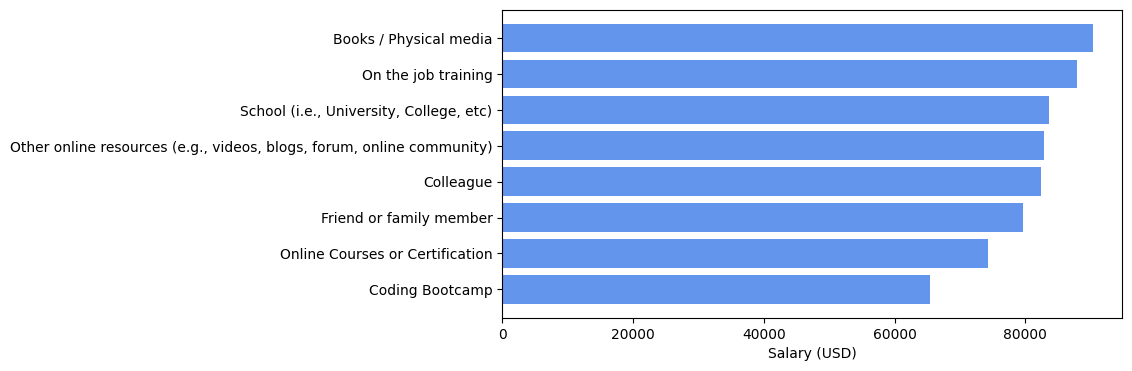

In [14]:
exploded_df = filtered_transformed_df.select(
    posexplode(col("LearnCode_arr")).alias("attribute_index", "attribute_value"), col("Salary_in_USD")
).filter(col("attribute_value") == 1)
lc_df = exploded_df.groupBy("attribute_index").agg(avg("Salary_in_USD").alias("average_salary")).sort("average_salary").toPandas()
plt.figure(figsize=(8, 4))
mapped_name = [ k for a_idx in lc_df["attribute_index"] for k, v in learn_code_map.items() if a_idx == v]
plt.barh(mapped_name, lc_df["average_salary"], color="cornflowerblue")
plt.xlabel("Salary (USD)")
plt.show()

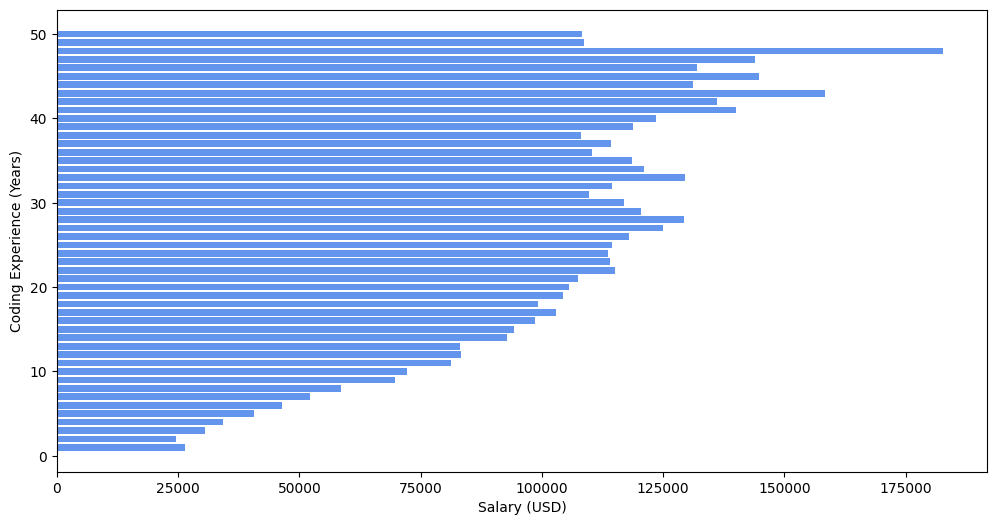

In [15]:
yc_df = filtered_transformed_df.groupBy("YearsCode").agg(avg("Salary_in_USD").alias("average_salary")).toPandas()
plt.figure(figsize=(12, 6))
plt.barh(yc_df["YearsCode"], yc_df["average_salary"], color="cornflowerblue")
plt.xlabel("Salary (USD)")
plt.ylabel("Coding Experience (Years)")
plt.show()

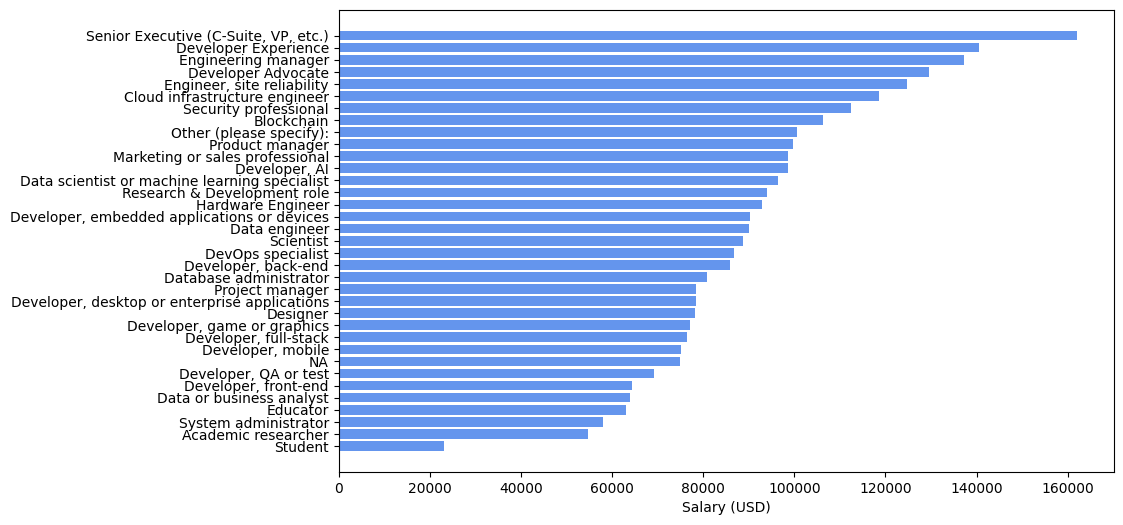

In [16]:
dt_df = filtered_transformed_df.groupBy("DevType").agg(avg("Salary_in_USD").alias("average_salary")).sort("average_salary").toPandas()
plt.figure(figsize=(10, 6))
plt.barh(dt_df["DevType"], dt_df["average_salary"], color="cornflowerblue")
plt.xlabel("Salary (USD)")
plt.show()

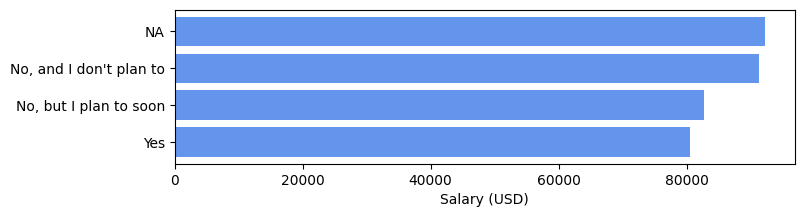

In [17]:
ai_df = filtered_transformed_df.groupBy("AISelect").agg(avg("Salary_in_USD").alias("average_salary")).sort("average_salary").toPandas()
plt.figure(figsize=(8, 2))
plt.barh(ai_df["AISelect"], ai_df["average_salary"], color="cornflowerblue")
plt.xlabel("Salary (USD)")
plt.show()

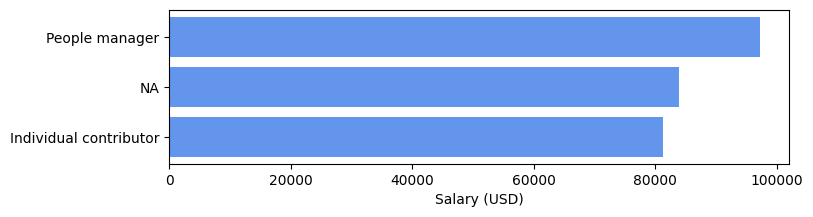

In [18]:
ip_df = filtered_transformed_df.groupBy("ICorPM").agg(avg("Salary_in_USD").alias("average_salary")).sort("average_salary").toPandas()
plt.figure(figsize=(8, 2))
plt.barh(ip_df["ICorPM"], ip_df["average_salary"], color="cornflowerblue")
plt.xlabel("Salary (USD)")
plt.show()

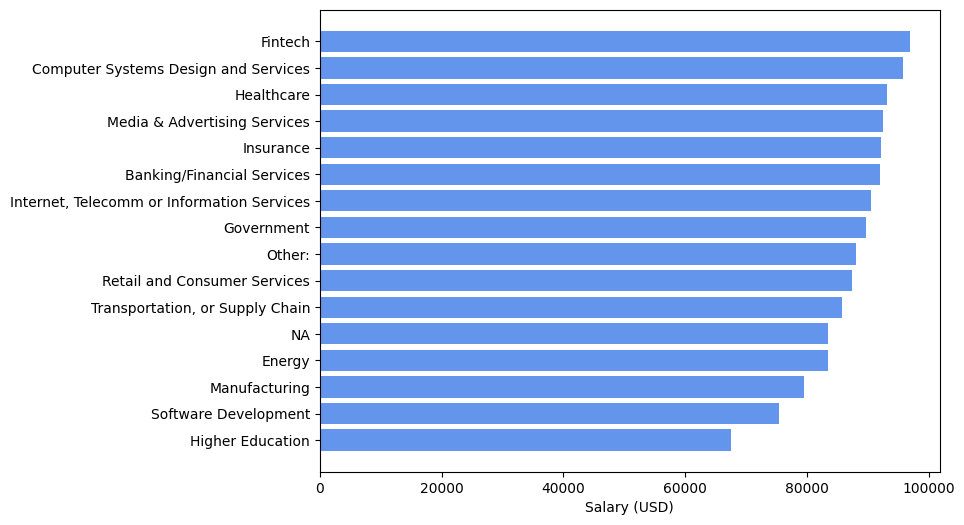

In [19]:
i_df = filtered_transformed_df.groupBy("Industry").agg(avg("Salary_in_USD").alias("average_salary")).sort("average_salary").toPandas()
plt.figure(figsize=(8, 6))
plt.barh(i_df["Industry"], i_df["average_salary"], color="cornflowerblue")
plt.xlabel("Salary (USD)")
plt.show()

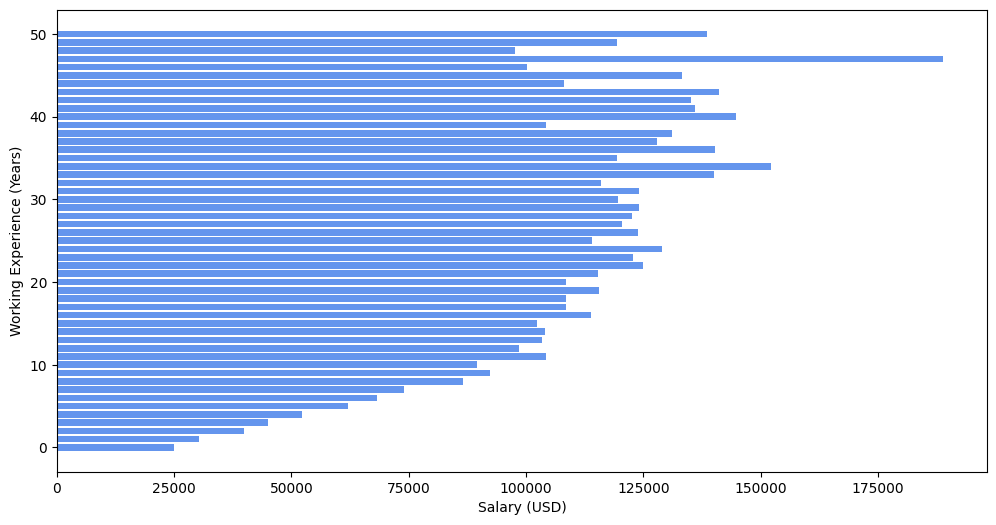

In [20]:
we_df = filtered_transformed_df.groupBy("WorkExp").agg(avg("Salary_in_USD").alias("average_salary")).sort("average_salary").toPandas()
plt.figure(figsize=(12, 6))
plt.barh(we_df["WorkExp"], we_df["average_salary"], color="cornflowerblue")
plt.xlabel("Salary (USD)")
plt.ylabel("Working Experience (Years)")
plt.show()

In [55]:
# selected columns for model training
selected_filtered_transformed_df = filtered_transformed_df.select(
    "MainBranch_index", "Age_index", "Country_reduced","Employment_index", "RemoteWork_index", "EdLevel_index", "LearnCode_arr", "YearsCode", 
    "DevType_index", "OrgSize_index", "LanguageHaveWorkedWith_arr", "DatabaseHaveWorkedWith_arr", "PlatformHaveWorkedWith_arr",
    "WebframeHaveWorkedWith_arr", "EmbeddedHaveWorkedWith_arr", "MiscTechHaveWorkedWith_arr", "ToolsTechHaveWorkedWith_arr", 
    "NEWCollabToolsHaveWorkedWith_arr", "OpSysProfessionalUse_arr", "OfficeStackAsyncHaveWorkedWith_arr", 
    "OfficeStackSyncHaveWorkedWith_arr", "AISearchDevHaveWorkedWith_arr", "ICorPM_index", "Industry_index", "WorkExp", "Salary_in_USD"
)

In [56]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, Imputer

In [57]:
# flatten arr features to invividual column
columns_to_flatten = [
    "LearnCode_arr", "LanguageHaveWorkedWith_arr", "DatabaseHaveWorkedWith_arr", "PlatformHaveWorkedWith_arr", "WebframeHaveWorkedWith_arr", 
    "EmbeddedHaveWorkedWith_arr", "MiscTechHaveWorkedWith_arr", "ToolsTechHaveWorkedWith_arr", "NEWCollabToolsHaveWorkedWith_arr", 
    "OpSysProfessionalUse_arr", "OfficeStackAsyncHaveWorkedWith_arr", "OfficeStackSyncHaveWorkedWith_arr", "AISearchDevHaveWorkedWith_arr"
]

new_columns = []
for column in columns_to_flatten:
    max_length = selected_filtered_transformed_df.selectExpr(f"size({column})").rdd.max()[0]
    for i in range(max_length):
        new_columns.append(f"{column}_{i}")
        selected_filtered_transformed_df = selected_filtered_transformed_df.withColumn(f"{column}_{i}", col(column).getItem(i))
selected_filtered_transformed_df = selected_filtered_transformed_df.drop(*columns_to_flatten)

# assign index to each country
indexer = StringIndexer(inputCol="Country_reduced", outputCol="Country_indexed")
selected_filtered_transformed_df = indexer.fit(selected_filtered_transformed_df).transform(selected_filtered_transformed_df)

In [58]:
# define imputer
imputers = [
    Imputer(
        inputCols=["YearsCode", "WorkExp"], 
        outputCols=["YearsCode", "WorkExp"]
    ).setStrategy("mean"),
    Imputer(
        inputCols=["MainBranch_index", "Age_index", "Country_indexed", "Employment_index", "RemoteWork_index", "EdLevel_index",
                   "DevType_index", "OrgSize_index", "ICorPM_index", "Industry_index"], 
        outputCols=["MainBranch_index", "Age_index", "Country", "Employment_index", "RemoteWork_index", "EdLevel_index",
                    "DevType_index", "OrgSize_index", "ICorPM_index", "Industry_index"] 
    ).setStrategy("mode"),
    Imputer(
        inputCols=new_columns,
        outputCols=new_columns
    ).setStrategy("mean")
]

# apply imputer
for imputer in imputers:
    selected_filtered_transformed_df = imputer.fit(selected_filtered_transformed_df).transform(selected_filtered_transformed_df)

24/12/15 20:16:25 WARN DAGScheduler: Broadcasting large task binary with size 1158.2 KiB
                                                                                

In [59]:
# aggregate array features to a signle column
new_columns.append("YearsCode")
new_columns.append("WorkExp")
arr_feature_assembler = VectorAssembler(
    inputCols = new_columns,
    outputCol = "arr_features"
)
selected_filtered_transformed_df = arr_feature_assembler.transform(selected_filtered_transformed_df)

In [60]:
# aggregate categorical features to a signle column
cat_feature_assembler = VectorAssembler(
    inputCols = ["MainBranch_index", "Age_index", "Country_indexed", "Employment_index", "RemoteWork_index", "EdLevel_index",
                 "DevType_index", "OrgSize_index", "ICorPM_index", "Industry_index"],
    outputCol = "cat_features"
)
selected_filtered_transformed_df = cat_feature_assembler.transform(selected_filtered_transformed_df)

In [61]:
# transform salary_in_USD to different classes 
selected_filtered_transformed_df = selected_filtered_transformed_df.withColumn(
    "label", generate_label_udf(col("Salary_in_USD"))
)
selected_filtered_transformed_df = selected_filtered_transformed_df.filter(~col("label").isNull())

In [62]:
model_ready_df = selected_filtered_transformed_df.select("arr_features", "cat_features", "label")
# split data to 80% training 20% testing
train_df, test_df = model_ready_df.randomSplit([0.8, 0.2], seed=10)

In [63]:
# Random Forest model
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rf = RandomForestClassifier(featuresCol="cat_features", labelCol="label", numTrees=50, maxDepth=12, maxBins=50)
rf_model = rf.fit(train_df)

24/12/15 20:16:42 WARN DAGScheduler: Broadcasting large task binary with size 1003.2 KiB
24/12/15 20:16:43 WARN DAGScheduler: Broadcasting large task binary with size 1329.2 KiB
24/12/15 20:16:43 WARN DAGScheduler: Broadcasting large task binary with size 1940.1 KiB
24/12/15 20:16:43 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/12/15 20:16:43 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
24/12/15 20:16:44 WARN DAGScheduler: Broadcasting large task binary with size 1140.9 KiB
24/12/15 20:16:44 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
24/12/15 20:16:45 WARN DAGScheduler: Broadcasting large task binary with size 1865.0 KiB
24/12/15 20:16:45 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
24/12/15 20:16:46 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/12/15 20:16:46 WARN DAGScheduler: Broadcasting large task binary with size 22.0 MiB
24/12/15 20:16:47 WARN DAGScheduler: 

In [64]:
# RF performance on testing data set
test_rf_predictions = rf_model.transform(test_df)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(test_rf_predictions)
print(f"Test Accuracy: {accuracy:.2f}")

24/12/15 20:19:33 WARN DAGScheduler: Broadcasting large task binary with size 26.0 MiB
[Stage 70:=====>                                                   (1 + 9) / 10]

Test Accuracy: 0.40


In [76]:
import tensorflow as tf
from pyspark.ml.linalg import SparseVector

def convert_features_to_dense(row):
    features = row['arr_features'].toArray()
    rf_probability = row['probability'].toArray()
    label = row['label']
    return (features, rf_probability, label)

# convert data for ANN models, combining with results from RF model
training_rf_predictions = rf_model.transform(train_df) # from RF 
dense_converted_rdd = training_rf_predictions.rdd.map(convert_features_to_dense)
ann_dataset = dense_converted_rdd.collect()
arr_features, rf_probs, labels = zip(*ann_dataset)
tf_arr_dataset = tf.data.Dataset.from_tensor_slices(((list(arr_features), list(rf_probs)), list(labels))).batch(200)

24/12/15 20:26:03 WARN DAGScheduler: Broadcasting large task binary with size 26.0 MiB
                                                                                

In [83]:
# define combined model RF results concatenate with ANN result with additional layers for final prediction
def combined_model(input_shape, rf_input_shape):
    features_input = tf.keras.layers.Input(shape=input_shape, name="features_input")
    rf_probs_input = tf.keras.layers.Input(shape=rf_input_shape, name="rf_probs_input")

    # ANN layers with BatchNormalization and Dropout
    x = tf.keras.layers.Dense(512)(features_input)  # Dense layer
    x = tf.keras.layers.BatchNormalization()(x)     # BatchNormalization
    x = tf.keras.layers.Activation('relu')(x)       # Activation function (ReLU)
    x = tf.keras.layers.Dropout(0.5)(x)             # Dropout (50%)
    
    x = tf.keras.layers.Dense(256)(x)               # Dense layer
    x = tf.keras.layers.BatchNormalization()(x)     # BatchNormalization
    x = tf.keras.layers.Activation('relu')(x)       # Activation function (ReLU)
    x = tf.keras.layers.Dropout(0.5)(x)             # Dropout (50%)
    
    x = tf.keras.layers.Dense(128)(x)               # Dense layer
    x = tf.keras.layers.BatchNormalization()(x)     # BatchNormalization
    x = tf.keras.layers.Activation('relu')(x)       # Activation function (ReLU)
    x = tf.keras.layers.Dropout(0.5)(x)             # Dropout (50%)
    
    x = tf.keras.layers.Dense(64)(x)                # Dense layer
    x = tf.keras.layers.BatchNormalization()(x)     # BatchNormalization
    x = tf.keras.layers.Activation('relu')(x)       # Activation function (ReLU)
    x = tf.keras.layers.Dropout(0.5)(x)             # Dropout (50%)
    
    # Final Dense Layer for ANN output
    ann_output = tf.keras.layers.Dense(20, activation='softmax')(x)  # ANN probabilities (22-dimensional)
    
    # Combine ANN and RF outputs
    combined = tf.keras.layers.Add()([ann_output, rf_probs_input])  # Element-wise addition
    combined = tf.keras.layers.LayerNormalization()(combined)
    
    # Additional layers for final prediction
    combined = tf.keras.layers.Dense(80)(combined)                # Dense layer
    combined = tf.keras.layers.BatchNormalization()(combined)     # BatchNormalization
    combined = tf.keras.layers.Activation('relu')(combined)       # Activation function (ReLU)
    combined = tf.keras.layers.Dropout(0.5)(combined)             # Dropout (50%)

    combined = tf.keras.layers.Dense(40)(combined)                # Dense layer
    combined = tf.keras.layers.BatchNormalization()(combined)     # BatchNormalization
    combined = tf.keras.layers.Activation('relu')(combined)       # Activation function (ReLU)
    combined = tf.keras.layers.Dropout(0.5)(combined)             # Dropout (50%)

    final_output = tf.keras.layers.Dense(20, activation='softmax')(combined)
    
    # Define the complete model
    model = tf.keras.Model(inputs=[features_input, rf_probs_input], outputs=final_output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [84]:
model = combined_model((376,), (20,))
model.fit(tf_arr_dataset, epochs=20)

Epoch 1/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1908 - loss: 3.0478    
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4034 - loss: 2.2736
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4203 - loss: 2.1590
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4364 - loss: 2.0878
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4474 - loss: 2.0163
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4626 - loss: 1.9480
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4756 - loss: 1.8876
Epoch 8/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4846 - loss: 1.8555
Epoch 9/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4927 - loss: 1.8160
Epoch 10/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5009 - loss: 1.7842
Epoch 11/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5077 - loss: 1.7618
Epoch 12/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/

In [81]:
### testing
test_dense_rdd = test_rf_predictions.rdd.map(convert_features_to_dense)
test_dataset = test_dense_rdd.collect()
test_arr_features, test_rf_probs, test_labels = zip(*test_dataset)
test_tf_dataset = tf.data.Dataset.from_tensor_slices(((list(test_arr_features), list(test_rf_probs)), list(test_labels))).batch(200)

24/12/15 20:27:31 WARN DAGScheduler: Broadcasting large task binary with size 26.0 MiB
                                                                                

In [85]:
loss, accuracy = model.evaluate(test_tf_dataset)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3900 - loss: 2.1568   
Test Loss: 2.183021068572998
Test Accuracy: 0.38377487659454346


In [39]:
spark.stop()